## 1. Importar Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

print("✓ Librerías importadas")

✓ Librerías importadas


## 2. Cargar Datos

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

test_ids = df_test['ID'].copy()

print(f"Train: {df_train.shape[0]:,} registros")
print(f"Test: {df_test.shape[0]:,} registros")

Train: 692,500 registros
Test: 296,786 registros


## 3. Preprocesamiento Simple

Estrategia minimalista: solo conversiones básicas.

In [8]:
def simple_preprocess(df):
    """
    Preprocesamiento minimalista sin feature engineering
    """
    df = df.copy()
    
    # Eliminar columnas (incluyendo duplicados)
    cols_to_drop = ['ID', 'PERIODO_ACADEMICO']
    if 'F_TIENEINTERNET.1' in df.columns:
        cols_to_drop.append('F_TIENEINTERNET.1')
    df = df.drop(columns=cols_to_drop, errors='ignore')
    
    # Variables binarias Si/No
    binary_cols = ['F_TIENEINTERNET', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 
                   'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR']
    for col in binary_cols:
        if col in df.columns:
            df[col] = df[col].fillna('No')
            df[col] = df[col].map({'Si': 1, 'No': 0}).fillna(0)
    
    # E_PRIVADO_LIBERTAD
    if 'E_PRIVADO_LIBERTAD' in df.columns:
        df['E_PRIVADO_LIBERTAD'] = df['E_PRIVADO_LIBERTAD'].fillna('N')
        df['E_PRIVADO_LIBERTAD'] = df['E_PRIVADO_LIBERTAD'].map({'S': 1, 'N': 0}).fillna(0)
    
    # Estrato (simple)
    estrato_map = {'Estrato 1': 1, 'Estrato 2': 2, 'Estrato 3': 3,
                   'Estrato 4': 4, 'Estrato 5': 5, 'Estrato 6': 6, 'Sin Estrato': 0}
    if 'F_ESTRATOVIVIENDA' in df.columns:
        df['F_ESTRATOVIVIENDA'] = df['F_ESTRATOVIVIENDA'].fillna('Sin Estrato')
        df['F_ESTRATOVIVIENDA'] = df['F_ESTRATOVIVIENDA'].map(estrato_map).fillna(0)
    
    # Horas de trabajo (promedios simples)
    horas_map = {'Menos de 10 horas': 5, 'Entre 11 y 20 horas': 15, 
                 'Entre 21 y 30 horas': 25, 'Más de 30 horas': 35, '0': 0}
    if 'E_HORASSEMANATRABAJA' in df.columns:
        df['E_HORASSEMANATRABAJA'] = df['E_HORASSEMANATRABAJA'].fillna('0')
        df['E_HORASSEMANATRABAJA'] = df['E_HORASSEMANATRABAJA'].map(horas_map).fillna(0)
    
    # Valor matrícula (promedios simples)
    valor_map = {'Menos de 500 mil': 0.25, 'Entre 500 mil y menos de 1 millón': 0.75,
                 'Entre 1 millón y menos de 2.5 millones': 1.75, 
                 'Entre 2.5 millones y menos de 4 millones': 3.25,
                 'Entre 4 millones y menos de 5.5 millones': 4.75,
                 'Entre 5.5 millones y menos de 7 millones': 6.25,
                 'Más de 7 millones': 7.75, 'No pagó matrícula': 0}
    if 'E_VALORMATRICULAUNIVERSIDAD' in df.columns:
        df['E_VALORMATRICULAUNIVERSIDAD'] = df['E_VALORMATRICULAUNIVERSIDAD'].fillna('No pagó matrícula')
        df['E_VALORMATRICULAUNIVERSIDAD'] = df['E_VALORMATRICULAUNIVERSIDAD'].map(valor_map).fillna(0)
    
    # Educación padres (simple ordinal)
    edu_map = {'Ninguno': 0, 'Primaria incompleta': 1, 'Primaria completa': 2,
               'Secundaria (Bachillerato) incompleta': 3, 'Secundaria (Bachillerato) completa': 4,
               'Técnica o tecnológica incompleta': 5, 'Técnica o tecnológica completa': 6,
               'Educación profesional incompleta': 7, 'Educación profesional completa': 8,
               'Postgrado': 9, 'No sabe': 0, 'No Aplica': 0}
    for col in ['F_EDUCACIONPADRE', 'F_EDUCACIONMADRE']:
        if col in df.columns:
            df[col] = df[col].fillna('No sabe')
            df[col] = df[col].map(edu_map).fillna(0)
    
    # Label encoding para categorías
    for col in ['E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO']:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].fillna('DESCONOCIDO'))
    
    return df

print("✓ Función de preprocesamiento simple definida")

✓ Función de preprocesamiento simple definida


In [9]:
# Aplicar preprocesamiento
df_train_proc = simple_preprocess(df_train)
df_test_proc = simple_preprocess(df_test)

print(f"✓ Preprocesamiento aplicado")
print(f"  Train: {df_train_proc.shape}")
print(f"  Test: {df_test_proc.shape}")

✓ Preprocesamiento aplicado
  Train: (692500, 18)
  Test: (296786, 17)


## 4. Preparar Datos

In [10]:
# Separar X e y
X = df_train_proc.drop('RENDIMIENTO_GLOBAL', axis=1)
y = df_train_proc['RENDIMIENTO_GLOBAL']

# Eliminar NaN en target
mask = y.notna()
X = X[mask]
y = y[mask]

print(f"Registros válidos: {len(y):,}")

# Codificar target
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Train: {X_train.shape[0]:,}")
print(f"Validation: {X_val.shape[0]:,}")

Registros válidos: 692,500
Train: 554,000
Validation: 138,500
Train: 554,000
Validation: 138,500


## 5. Entrenar Gradient Boosting

In [11]:
# Modelo Gradient Boosting
model = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbose=1
)

print("="*60)
print("Entrenando Gradient Boosting...")
print("="*60)

model.fit(X_train, y_train)

# Evaluar
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

print(f"\nTrain Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Entrenando Gradient Boosting...
      Iter       Train Loss   Remaining Time 
         1           1.3646           11.77m
         1           1.3646           11.77m
         2           1.3474           11.40m
         2           1.3474           11.40m
         3           1.3333           11.48m
         3           1.3333           11.48m
         4           1.3212           11.30m
         4           1.3212           11.30m
         5           1.3111           11.15m
         5           1.3111           11.15m
         6           1.3024           11.03m
         6           1.3024           11.03m
         7           1.2951           10.92m
         7           1.2951           10.92m
         8           1.2886           10.83m
         8           1.2886           10.83m
         9           1.2827           10.74m
         9           1.2827           10.74m
        10           1.2779           10.68m
        10           1.2779           10.68m
        20           1

## 6. Evaluación

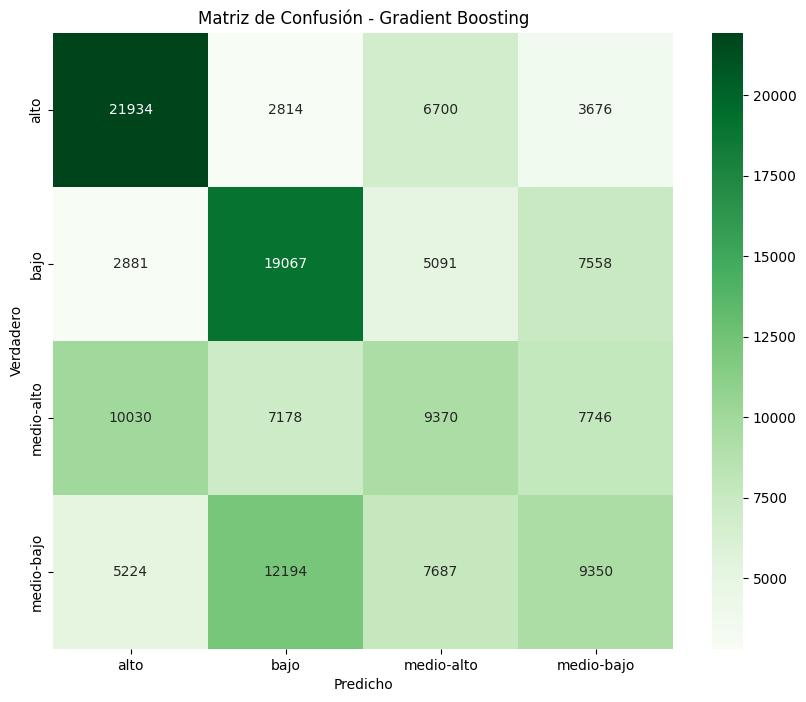


Reporte de Clasificación:
              precision    recall  f1-score   support

        alto       0.55      0.62      0.58     35124
        bajo       0.46      0.55      0.50     34597
  medio-alto       0.32      0.27      0.30     34324
  medio-bajo       0.33      0.27      0.30     34455

    accuracy                           0.43    138500
   macro avg       0.42      0.43      0.42    138500
weighted avg       0.42      0.43      0.42    138500



In [12]:
# Matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_)
plt.title('Matriz de Confusión - Gradient Boosting')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_val, y_val_pred, target_names=le_target.classes_))

## 7. Generar Predicciones

In [13]:
# Preparar test
X_test = df_test_proc.copy()

# Asegurar mismas columnas
missing_cols = set(X.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0
X_test = X_test[X.columns]

# Predecir
y_test_pred_encoded = model.predict(X_test)
y_test_pred = le_target.inverse_transform(y_test_pred_encoded)

# Submission
submission = pd.DataFrame({
    'ID': test_ids,
    'RENDIMIENTO_GLOBAL': y_test_pred
})

submission.to_csv('submission_alt1.csv', index=False)

print("✓ Archivo submission_alt1.csv creado")
print(submission.head(10))

✓ Archivo submission_alt1.csv creado
       ID RENDIMIENTO_GLOBAL
0  550236         medio-alto
1   98545         medio-alto
2  499179               alto
3  782980               bajo
4  785185               bajo
5   58495         medio-bajo
6  705444               alto
7  557548               alto
8  519909               bajo
9  832058               alto


## 8. Resumen

In [ ]:
print("="*80)
print("ENFOQUE ALTERNATIVO 1: GRADIENT BOOSTING SIMPLE")
print("="*80)

print(f"\n🔧 DIFERENCIAS vs Modelo Solución:")
print(f"  - Preprocesamiento minimalista (sin feature engineering)")
print(f"  - Gradient Boosting en lugar de Random Forest")
print(f"  - Sin índices compuestos")
print(f"  - Menos features ({X.shape[1]} vs ~26)")

print(f"\n📊 RESULTADOS:")
print(f"  Train Accuracy: {train_acc:.4f}")
print(f"  Validation Accuracy: {val_acc:.4f}")

print(f"\n💡 VENTAJAS:")
print(f"  + Más rápido de entrenar")
print(f"  + Menos overfitting potencial")
print(f"  + Código más simple")

print(f"\n⚠️ DESVENTAJAS:")
print(f"  - Posiblemente menor accuracy")
print(f"  - No aprovecha relaciones entre variables")
print(f"  - Features menos informativas")

print("\n" + "="*80)